In [1]:
from shapely.geometry import Polygon

In [2]:
square = Polygon(
    [(-84.237756, 33.904859), (-84.237756, 34.090426),
     (-83.833011, 34.090426), (-83.833011, 33.904859),
     (-84.237756, 33.904859)
    ])

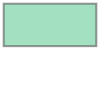

In [3]:
square

In [4]:
# 未使用
octagon = Polygon(
    [(-84.257756, 33.754859), (-84.297756, 33.904859), (-84.257756, 34.054859),
     (-83.787756, 34.154859),
     (-83.317756, 34.054859), (-83.287756, 33.904859), (-83.317756, 33.754859),
     (-83.787756, 33.654859),
    ])

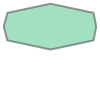

In [5]:
octagon

In [6]:
square_vertical = Polygon(
    [(-84.237756, 33.904859), (-84.237756, 34.890426),
     (-84.033011, 34.890426), (-84.033011, 33.904859)
    ])

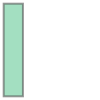

In [7]:
square_vertical

In [8]:
# Spark初期化
from pyspark.sql import SparkSession

from geospark.register import upload_jars
from geospark.utils import GeoSparkKryoRegistrator, KryoSerializer

upload_jars()

spark = SparkSession.\
    builder.\
    master("local[*]").\
    appName("geospark-study").\
    config("spark.serializer", KryoSerializer.getName).\
    config("spark.kryo.registrator", GeoSparkKryoRegistrator.getName) .\
    getOrCreate()

In [9]:
# GeoSpark初期化
from geospark.register import GeoSparkRegistrator
GeoSparkRegistrator.registerAll(spark)

True

In [10]:
# Polygon⇒DataFrame化準備
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType

from geospark.sql.types import GeometryType

schema = StructType([
    StructField('join_key', IntegerType()), # join_keyは結合用
    StructField('name', StringType()),
    StructField('geometry', GeometryType())
])

In [11]:
# ST_Intersectionは二つデータフレームを使用し、SQLで処理を行う関数のようなので、
# Polygonを1つもつデータフレームを複数用意する。
dic1 = [{'join_key': 1, 'name': 'square', 'geometry': square}]
df1 = spark.createDataFrame(dic1, schema)

In [12]:
dic2 = [{'join_key': 1, 'name': 'octagon', 'geometry': octagon}]
df2 = spark.createDataFrame(dic2, schema)

In [13]:
dic3 = [{'join_key': 1, 'name': 'square_v', 'geometry': square_vertical}]
df3 = spark.createDataFrame(dic3, schema)

In [14]:
# sqlで使えるようにする
df1.registerTempTable('square')
df2.registerTempTable('octagon')
df3.registerTempTable('square_v')

In [15]:
intersectioned = spark.sql("""
    select
        ST_Intersection(sq.geometry, sq_v.geometry)
    FROM
        square as sq
        cross join square_v as sq_v
            on sq.join_key = sq_v.join_key
""")

In [16]:
intersectioned.show()

+-----------------------------------+
|st_intersection(geometry, geometry)|
+-----------------------------------+
|               POLYGON ((-84.237...|
+-----------------------------------+



In [17]:
# ファイル出力・表示のためGeoPandasに移す
import geopandas as gpd
intersectioned_gdf = gpd.GeoDataFrame(
    intersectioned.collect(), columns=["geom"], geometry="geom"
)

In [18]:
intersectioned_gdf.to_file(r'out/intersectioned.shp')

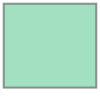

In [19]:
intersectioned_gdf.at[0, 'geom']

In [20]:
coords = intersectioned_gdf.at[0, 'geom'].exterior.coords
list(coords)

[(-84.237756, 33.904859),
 (-84.237756, 34.090426),
 (-84.033011, 34.090426),
 (-84.033011, 33.904859),
 (-84.237756, 33.904859)]

### ST_Intersectionは2つのポリゴンが重なっている部分のみを返す関数だったため、別の関数（ST_Union_Aggr）を試す。

In [22]:
# ST_Union_Aggrはデータフレームの列を指定し、
# すべてのジオメトリを結合するメソッドのようなので1つのデータフレームに加工する。
unioned_df13 = df1.union(df3)
unioned_df13.show()

+--------+--------+--------------------+
|join_key|    name|            geometry|
+--------+--------+--------------------+
|       1|  square|POLYGON ((-84.237...|
|       1|square_v|POLYGON ((-84.237...|
+--------+--------+--------------------+



In [23]:
unioned_df13.registerTempTable('squares')

In [24]:
unioned = spark.sql("""
    select
        ST_Union_Aggr(sq.geometry)
    FROM
        squares as sq
""")
unioned.show()

+-----------------------+
|st_union_aggr(geometry)|
+-----------------------+
|   POLYGON ((-84.237...|
+-----------------------+



In [25]:
# ファイル出力・表示のためGeoPandasに移す
import geopandas as gpd
unioned_gdf = gpd.GeoDataFrame(
    unioned.collect(), columns=['geom'], geometry='geom'
)

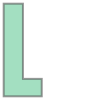

In [29]:
unioned_gdf.at[0, 'geom']

In [33]:
unioned_gdf.geometry

0    POLYGON ((-84.23776 33.90486, -84.23776 34.090...
Name: geom, dtype: geometry